# Neural Network Final Model - Monte Cimone, Italy

In [2]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [3]:
site = config.site
site_name = config.site_dict[site]
assert site == 'CMN', 'This script is only for Monte Cimone, Italy. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Monte Cimone, Italy.


### Loading & Initialising Data

In [4]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
6330,2019-04-05 05:00:00,1.0,0.705431,1.875723,-3.297430,-1.450922,-0.259171,-0.877290,-0.299471,-0.683114,...,-17.793198,7.194434,6.860065,-5.324897,6.872151,-5.750578,8.190823,2.323940,9.040844,12.330811
706,2005-11-06 01:00:00,0.0,-0.632025,1.103609,1.616200,-0.841302,-1.469130,6.004479,1.698824,0.108867,...,11.019250,15.261982,16.431217,2.552232,-11.499867,-1.236428,-1.490425,3.280166,10.709914,19.205310
7060,2020-05-11 21:00:00,1.0,1.165244,0.223781,2.940149,-0.727926,3.251177,6.507187,6.655251,0.200035,...,9.237605,4.680360,-3.132970,-0.347137,-12.473028,-9.099699,-4.088768,10.448282,10.576997,-1.123245
8066,2021-12-30 17:00:00,1.0,-0.287552,5.108218,4.417710,-0.536049,1.651906,-1.675036,6.042371,-0.664879,...,-16.788235,-11.326092,-12.593357,-15.501239,-8.192077,-24.847132,-14.830423,-0.037565,2.753454,7.191160
1157,2007-05-05 11:00:00,0.0,-0.846708,-4.291327,-4.067740,0.156740,2.643057,4.951472,4.826243,1.058608,...,2.079646,1.801358,7.482383,-7.156242,3.163686,0.953687,-0.166450,-3.936723,9.436218,19.564024


In [5]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 01:00:00 -> 2018-12-31 01:00:00. Length: 520
Val range: 2019-01-02 03:00:00 -> 2019-12-31 23:00:00. Length: 732
Test range: 2020-01-04 17:00:00 -> 2022-12-31 21:00:00. Length: 1894


### Model

In [60]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.5, 
                         learning_rate='constant', 
                         batch_size=250, 
                         early_stopping=False,
                         learning_rate_init=0.01,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

y_pred_val = nn_model.predict(X_val)
y_pred_train = nn_model.predict(X_train)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.923
Precision on Validation Set = 0.926
Recall on Training Set = 0.681
Recall on Validation Set = 0.591
F1 Score on Training Set = 0.784
F1 Score on Validation Set = 0.722


In [61]:
# evaluating model on test set

y_pred_test = nn_model.predict(X_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.934
Recall on Testing Set = 0.573
F1 Score on Testing Set = 0.710


In [62]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_CMN.joblib']

### Assessing Feature Importance

In [54]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

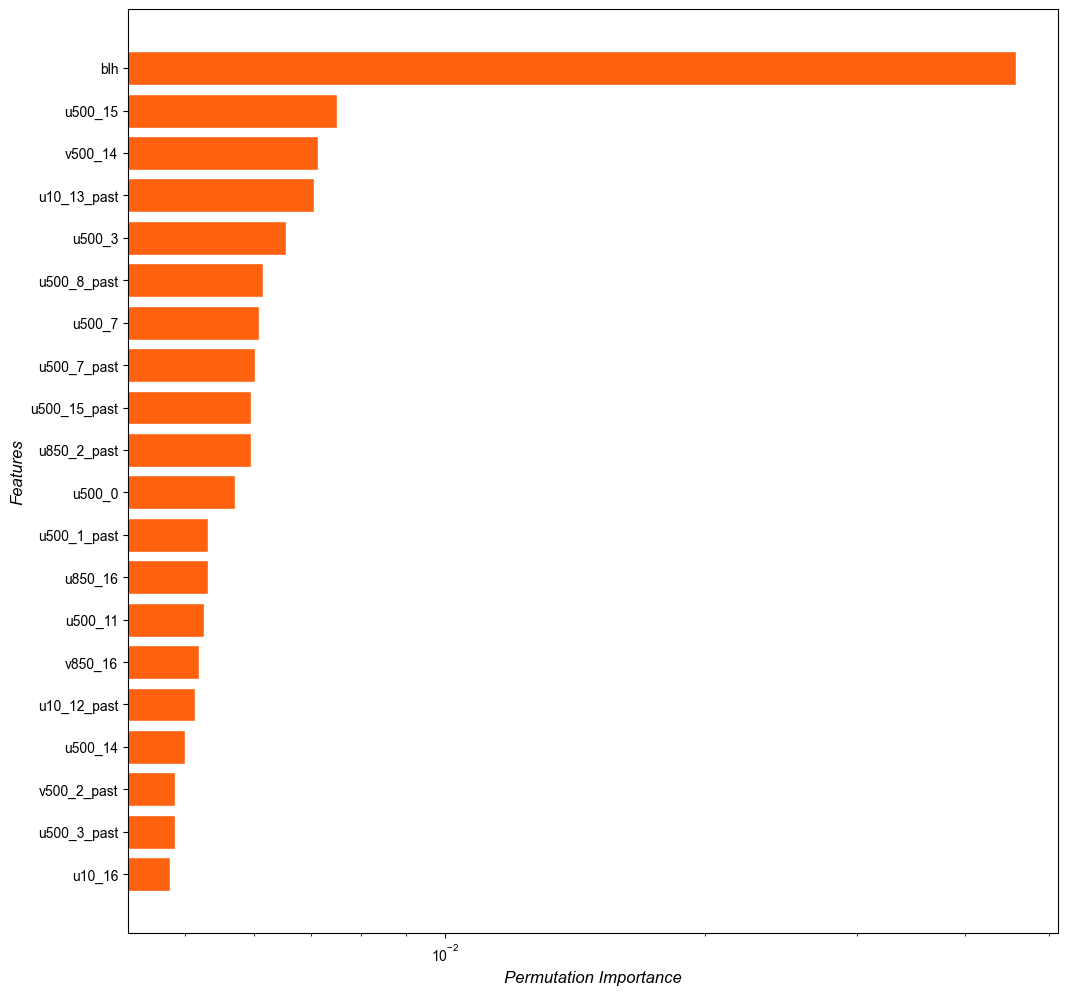

In [55]:
# plotting first 20 most important features in a histogram
fig, ax = plt.subplots(figsize=(12, 12))
sns.set_theme(style='ticks', font='Arial')

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:], color='#FF620E')

ax.set_xscale('log')

ax.set_ylabel('Features', fontsize=12, fontstyle='italic')
ax.set_xlabel('Permutation Importance', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importance (Testing Set)', fontsize=14)